In [1]:
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import math
from copy import deepcopy
%matplotlib inline

Reading data.
Finding contours.
Calculating PH.
Processing 0 out of 19 .
Processing 1 out of 19 .
Processing 2 out of 19 .
Processing 3 out of 19 .
Processing 4 out of 19 .
Processing 5 out of 19 .
Processing 6 out of 19 .
Processing 7 out of 19 .
Processing 8 out of 19 .
Processing 9 out of 19 .
Processing 10 out of 19 .
Processing 11 out of 19 .
Processing 12 out of 19 .
Processing 13 out of 19 .
Processing 14 out of 19 .
Processing 15 out of 19 .
Processing 16 out of 19 .
Processing 17 out of 19 .
Processing 18 out of 19 .
Processing 19 out of 19 .


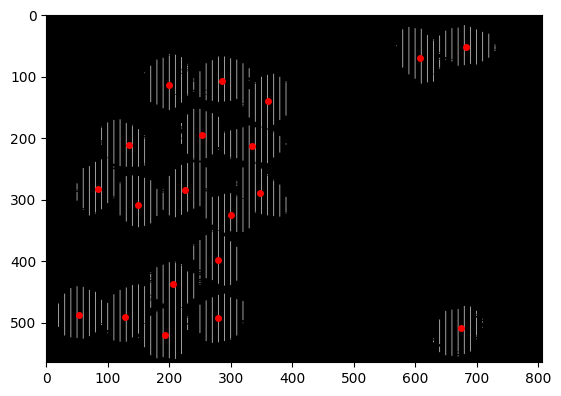

step= 10 lifethres= 3 1/alpha= 1.3
20 cells detected.


In [2]:
print("Reading data.")
alldata=[np.loadtxt('data'+str(i)+'.txt',delimiter=',') for i in range (1,130)]
alldata=np.array(alldata)
####Set binarythres, contourthres, and step
binarythres=120
contourthres=10
threeD_data=np.zeros((129,565,807))
step=10
boundary=[]
print("Finding contours.")
for i in range (0,807,step):
    b = alldata[:,:,i]
    buint=b.astype('uint8')
    ret, img_binary = cv2.threshold(buint, binarythres, 255,cv2.THRESH_BINARY)
    threeD_data[:,:,i]=img_binary
    contours, hierachy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    longContour=[]
    for k in range (0,len(contours)):
        if len(contours[k])>contourthres:
            newContour=np.array([[contours[k][j][0][1],contours[k][j][0][0],i] for j in range (0,len(contours[k]))])
            if len(longContour)==0:
                longContour=newContour
            else:
                longContour=np.vstack((longContour,newContour))
    if len(longContour)>0:
        if len(boundary)==0:
            boundary=longContour
        else:
            boundary=np.vstack((boundary,longContour))
threeD_datauint=threeD_data.astype('uint8')
#Calculate 2nd PH
print("Calculating PH.")
hc.PDList.from_alpha_filtration(boundary,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
pdlist = hc.PDList("pointcloud.pdgm")
pd = pdlist.dth_diagram(2)
pairs=pd.pairs()
##########Set death_thres, death_upper_thres, and lifethres
detectedpoints=np.array([])
death_thres=20
death_upper_thres=50
lifethres=3
for k in range (0,len(pairs)):
    if pairs[k].death>death_thres and pairs[k].death<death_upper_thres and pairs[k].death-pairs[k].birth>lifethres:
        Z=pairs[k].death_position
        A=np.array([])
        for i in range (1,4):
            v=np.array(Z[i])-np.array(Z[0])
            A=np.append(A,[v[0],v[1],v[2]])
        A=np.reshape(A,(int(len(A)/3),3))
        A_inv = np.linalg.inv(A)
        B=np.array([])
        for i in range (1,4):
            w=np.inner(np.array(Z[i]),np.array(Z[i]))-np.inner(np.array(Z[0]),np.array(Z[0]))
            B=np.append(B,[w])
        B=B/2
        C=np.array([])
        for i in range (0,3):
            z=np.inner(A_inv[i],B)
            C=np.append(C,[z])
        detectedpoints=np.append(detectedpoints,[C[0],C[1],C[2],pairs[k].death])
detectedpoints=np.reshape(detectedpoints,(int(len(detectedpoints)/4),4))
noiserate=1.3#####noiserate-1 is the epsilon in the paper.
one_over_alpha=1.3#####inverse of alpha.
threeD_datauint_copy=threeD_datauint
erasedresult=threeD_datauint_copy
diskdraw=np.zeros((129,565,807))
reduced_center_position=np.array([])
for repetition in range (0,len(detectedpoints)):
    maxindex=np.argmax(detectedpoints[:,3])
    maxvalue=detectedpoints[:,3][maxindex]
    diskradius=noiserate*maxvalue
    for i in range (max(0,int(detectedpoints[maxindex,0]-diskradius-2)),min(129,int(detectedpoints[maxindex,0]+diskradius+2))):
        for j in range (max(0,int(detectedpoints[maxindex,1]-diskradius-2)),min(565,int(detectedpoints[maxindex,1]+diskradius+2))):
            for k in range (max(0,int(detectedpoints[maxindex,2]-diskradius-2)),min(807,int(detectedpoints[maxindex,2]+diskradius+2))):
                if (i-detectedpoints[maxindex,0])**2+(j-detectedpoints[maxindex,1])**2+(k-detectedpoints[maxindex,2])**2<=diskradius**2:
                    diskdraw[i,j,k]=255
    newerasedpoints=0
    for i in range (max(0,int(detectedpoints[maxindex,0]-diskradius-2)),min(129,int(detectedpoints[maxindex,0]+diskradius+2))):
        for j in range (max(0,int(detectedpoints[maxindex,1]-diskradius-2)),min(565,int(detectedpoints[maxindex,1]+diskradius+2))):
            for k in range (max(0,int(detectedpoints[maxindex,2]-diskradius-2)),min(807,int(detectedpoints[maxindex,2]+diskradius+2))):
                if diskdraw[i,j,k]>0 and erasedresult[i,j,k]>0:
                    newerasedpoints=newerasedpoints+1
    if newerasedpoints>((4*maxvalue*maxvalue*maxvalue*math.pi)/3)/(one_over_alpha*step):
        reduced_center_position=np.append(reduced_center_position,detectedpoints[maxindex])
    detectedpoints[maxindex,3]=-1
    erasedresult=threeD_datauint_copy-diskdraw
    print("Processing", repetition, "out of", len(detectedpoints)-1,".")

reduced_result=np.reshape(reduced_center_position,(int(len(reduced_center_position)/4),4))
PROJ=reduced_result[:,1:3]
for i in range (0,len(reduced_result)):
    plt.plot(PROJ[i,1],PROJ[i,0], marker='.', markersize=8, color='red')
plt.imshow(threeD_datauint[70],cmap='gray')
plt.show()
print('step=',step, 'lifethres=',lifethres, '1/alpha=',one_over_alpha)
print(len(reduced_result),'cells detected.')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<IPython.core.display.Javascript object>


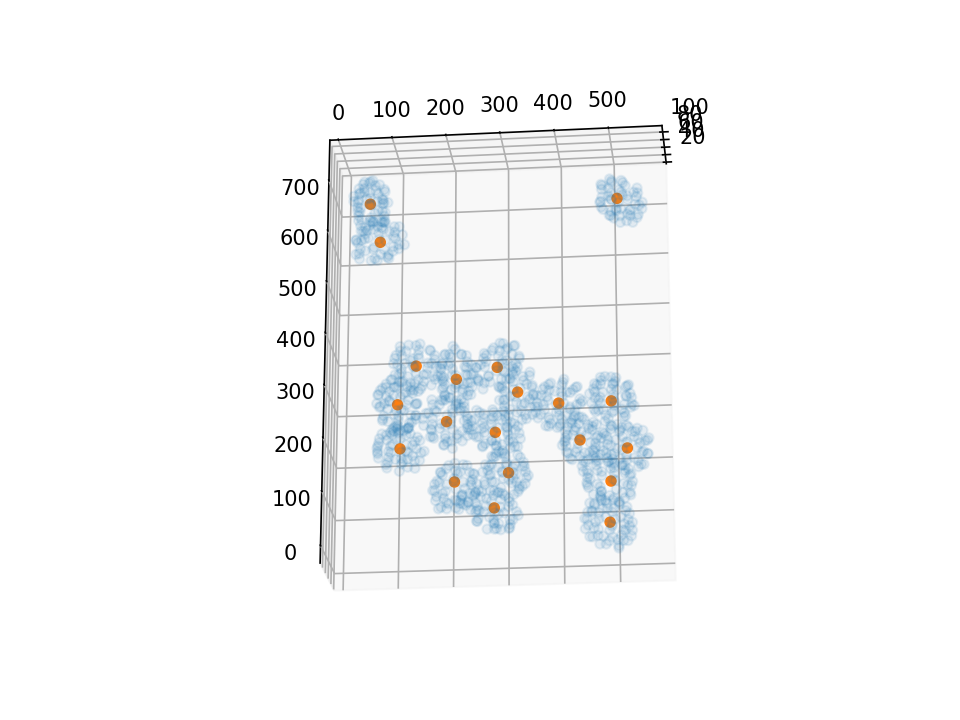

In [3]:
import open3d as o3d
points=o3d.utility.Vector3dVector(boundary)
pcd=o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
downpcd_random=pcd.uniform_down_sample(every_k_points=int(len(boundary)/1000))#####1000くらいになるようにダウンサンプリング
boundary_random=np.asarray(downpcd_random.points)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(boundary_random[:,0],boundary_random[:,1],boundary_random[:,2],alpha=0.1)
ax.scatter(reduced_result[:,0],reduced_result[:,1],reduced_result[:,2],alpha=1)
ax.set_box_aspect((0.2,0.75,1))
plt.show()